In [1]:
import sys
import os
sys.path.append('/Users/zhoupeng/Desktop/Athena V2')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from athena import Strategy, Backtest
from athena.data import CryptoDataHandler
import pandas as pd
import matplotlib.pyplot as plt

from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [4]:
data_handler = CryptoDataHandler(start_date='20200101', end_date='20241201')

In [5]:
data_directory = "/Users/zhoupeng/Desktop/crypto_database/data/daily"

prices_df = data_handler.create_prices_dataframe(data_directory, fields=['Open', 'Close'])

In [6]:
# 定义动量因子

momentum_window = 10

# 创建添加动量因子的新数据表
factors_df = pd.DataFrame(index=prices_df.index)

# 遍历每个标的，计算动量因子
for symbol in prices_df.columns.levels[0]:  # 获取交易标的符号
    if "Close" in prices_df[symbol].columns:  # 确保存在 Close 列
        # 提取收盘价列
        close_prices = prices_df[(symbol, "Close")]

        # 清洗数据：转换为数值（非数值替换为 NaN）
        close_prices = pd.to_numeric(close_prices, errors="coerce")

        # 填补缺失值（根据业务需求填充，如前向填充或移除）
        close_prices = close_prices.fillna(method="ffill").fillna(method="bfill")

        # 计算动量因子
        momentum = close_prices / close_prices.shift(momentum_window) - 1

        # 将动量因子存储到新表中
        factors_df[symbol] = momentum

# 为动量添加多层索引（symbol -> Momentum）
factors_df.columns = pd.MultiIndex.from_product([factors_df.columns, ["momentum"]])

In [7]:
data_handler = CryptoDataHandler(start_date='20200111', end_date='20200301')
prices_df = data_handler.create_prices_dataframe(data_directory, fields=['Open', 'Close'])

In [8]:
from athena.lib import calculate_benchmark_net_value

# 比特币作为benchmark
benchmark = prices_df['BTCUSDT']
benchmark = calculate_benchmark_net_value(benchmark)

In [9]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        pass

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factors_df.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'momentum') # 从高到低排因子

        #print(sorted_factor_series)前期交易所只有6个标的
        long_and_short_amount = len(sorted_factor_series) / 2
        if len(sorted_factor_series) >= 20:
           long_and_short_amount = 10
        #long_and_short_amount = 3

        print('因子排名前的股票:')
        print(sorted_factor_series.iloc[:int(long_and_short_amount)].index.tolist())
        long_stocks = sorted_factor_series.iloc[:int(long_and_short_amount)].index.tolist()

        print('因子排名后的股票:')
        print(sorted_factor_series.iloc[int(-long_and_short_amount):].index.tolist())
        short_stocks = sorted_factor_series.iloc[int(-long_and_short_amount):].index.tolist()

        target_percent = 1 / (int(long_and_short_amount)*2)

        print("当前cash:", self.broker.cash)
        print("当前assets value:", self.broker.assets_value)
        # 平仓
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])

                print("当前cash:", self.broker.cash)
                print("当前assets value:", self.broker.assets_value)
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])

                print("当前cash:", self.broker.cash)
                print("当前assets value:", self.broker.assets_value)
        
        # 这里的cash和assets value都应该被正常更新了

        # 调仓
        for stock in long_stocks:
            print("新开多仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=False)

            print("当前cash:", self.broker.cash)
            print("当前assets value:", self.broker.assets_value)
        for stock in short_stocks:
            print("新开空仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=True)

            print("当前cash:", self.broker.cash)
            print("当前assets value:", self.broker.assets_value)

        print("----------------------")
    
backtest = Backtest(SortedFactorInvestStrategy, prices_df, commission=0, cash=100_0000, benchmark=benchmark)
res = backtest.run()


----------------------
2020-01-11 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前的股票:
['BCHUSDT', 'BTCUSDT', 'LTCUSDT']
因子排名后的股票:
['ETHUSDT', 'EOSUSDT', 'XRPUSDT']
当前cash: 1000000
当前assets value: 0
新开多仓/调仓: BCHUSDT
当前cash: 835000.0001
当前assets value: 164999.9999
新开多仓/调仓: BTCUSDT
当前cash: 670000.0003
当前assets value: 329999.9997
新开多仓/调仓: LTCUSDT
当前cash: 505000.0005
当前assets value: 494999.9995
新开空仓/调仓: ETHUSDT
当前cash: 340000.0007
当前assets value: 659999.9993
新开空仓/调仓: EOSUSDT
当前cash: 175000.0008
当前assets value: 824999.9992
新开空仓/调仓: XRPUSDT
当前cash: 10000.0009
当前assets value: 989999.9991
----------------------
----------------------
2020-02-10 00:00:00: 
我目前持仓情况:
多头仓位: ['BCHUSDT', 'BTCUSDT', 'LTCUSDT']
空头仓位: ['ETHUSDT', 'EOSUSDT', 'XRPUSDT']
因子排名前的股票:
['ETHUSDT', 'XTZUSDT', 'BCHUSDT', 'LINKUSDT', 'TRXUSDT', 'EOSUSDT', 'XLMUSDT', 'DASHUSDT']
因子排名后的股票:
['XRPUSDT', 'ADAUSDT', 'XMRUSDT', 'LTCUSDT', 'BTCUSDT', 'ETCUSDT', 'ATOMUSDT', 'ZECUSDT']
当前cash: 10000.0009
当前assets value: 980228.3681
关多仓: BTCUSDT

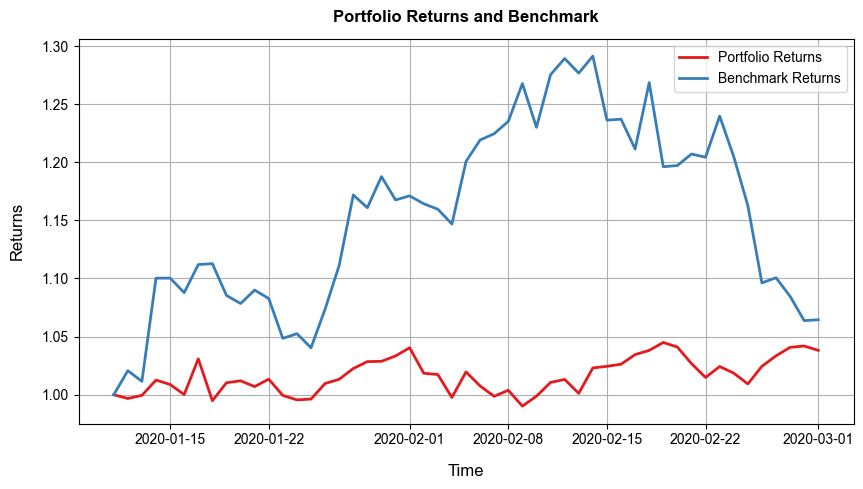

In [10]:
from athena.plotting import Visualization

visualization = Visualization(res)
visualization.plot_portfolio_returns(use_benchmark=True)

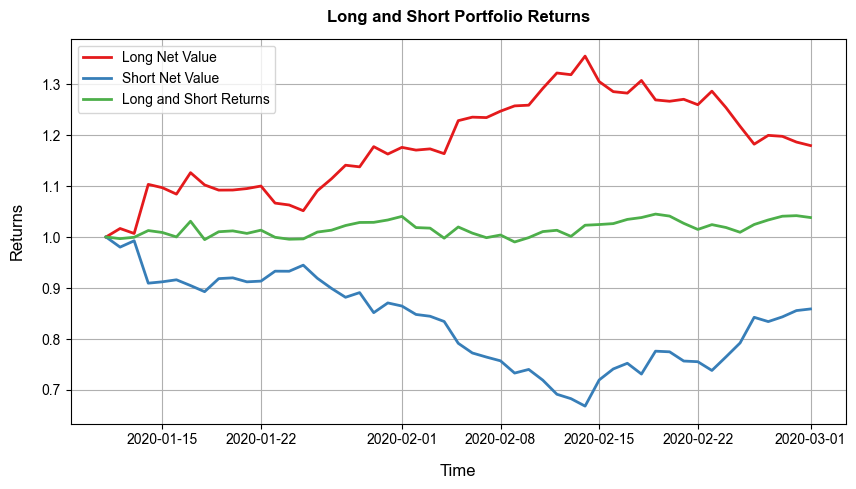

In [11]:
visualization.plot_long_short_portfolio_returns()

In [12]:
# 计算回测指标
metrics = visualization.calculate_metrics()
print("Backtest Metrics: \n")
for key, value in metrics.items():
    print(key+": "+ value)

Backtest Metrics: 

strategy_annualized_return: 20.34%
benchmark_annualized_return: 36.18%
strategy_annualized_volatility: 18.85%
benchmark_annualized_volatility: 43.81%
strategy_max_drawdown: -4.82%
benchmark_max_drawdown: -17.62%
sharpe_ratio: 0.97
alpha: 13.89%


因子分层测回测 momentum, Bucket 1/3...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 1111934.484
因子分层测回测 momentum, Bucket 2/3...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 1200388.286
因子分层测回测 momentum, Bucket 3/3...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 1308023.299


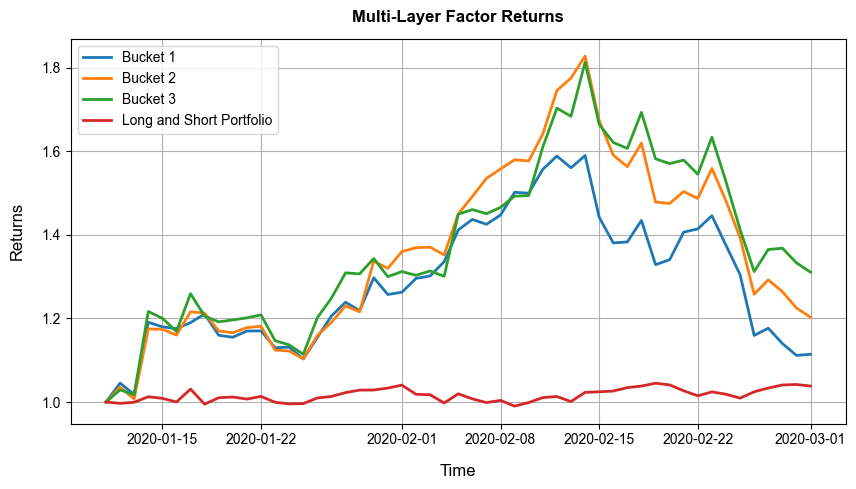

In [13]:
from athena.factor_research import run_factor_multiple_returns

# 对动量因子进行分层测试（例如分为5组）
layered_results = run_factor_multiple_returns(prices_df, factors_df, 'momentum', num_buckets=3)
visualization.plot_factor_multiple_returns(layered_results, res.net_value)